<a href="https://colab.research.google.com/github/jabir-al-nahian/mental-health-analysis-ml/blob/main/Mental_Health_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!ls

mental-heath-in-tech-2016_20161114.csv	sample_data


In [ ]:
# Data import
survey_2016 = pd.read_csv('/content/mental-heath-in-tech-2016_20161114.csv')

In [ ]:
# ----------- CLEANING THE DATA -----------
# Column rename
renamed_columns = ['self_empl_flag', 'comp_no_empl', 'tech_comp_flag', 'tech_role_flag', 'mh_coverage_flag',
                  'mh_coverage_awareness_flag', 'mh_employer_discussion', 'mh_resources_provided', 'mh_anonimity_flag',
                  'mh_medical_leave', 'mh_discussion_neg_impact', 'ph_discussion_neg_impact', 'mh_discussion_cowork',
                  'mh_discussion_supervis', 'mh_eq_ph_employer', 'mh_conseq_coworkers', 'mh_coverage_flag2', 'mh_online_res_flag',
                  'mh_diagnosed&reveal_clients_flag', 'mh_diagnosed&reveal_clients_impact', 'mh_diagnosed&reveal_cowork_flag', 'mh_cowork_reveal_neg_impact',
                  'mh_prod_impact', 'mh_prod_impact_perc', 'prev_employers_flag', 'prev_mh_benefits', 'prev_mh_benefits_awareness',
                  'prev_mh_discussion', 'prev_mh_resources', 'prev_mh_anonimity', 'prev_mh_discuss_neg_conseq', 'prev_ph_discuss_neg_conseq',
                  'prev_mh_discussion_cowork', 'prev_mh_discussion_supervisor', 'prev_mh_importance_employer', 'prev_mh_conseq_coworkers',
                  'future_ph_specification', 'why/why_not', 'future_mh_specification', 'why/why_not2', 'mh_hurt_on_career', 'mh_neg_view_cowork',
                  'mh_sharing_friends/fam_flag', 'mh_bad_response_workplace', 'mh_for_others_bad_response_workplace', 'mh_family_hist',
                  'mh_disorder_past', 'mh_disorder_current', 'yes:what_diagnosis?', 'maybe:whats_your_diag', 'mh_diagnos_proffesional',
                  'yes:condition_diagnosed', 'mh_sought_proffes_treatm', 'mh_eff_treat_impact_on_work', 'mh_not_eff_treat_impact_on_work',
                  'age', 'sex', 'country_live', 'live_us_teritory', 'country_work', 'work_us_teritory', 'work_position', 'remote_flag']
survey_2016.columns = renamed_columns

# Sex column needs to be recoded (number of unique values = 70)
survey_2016['sex'].replace(to_replace = ['Male', 'male', 'Male ', 'M', 'm',
       'man', 'Cis male', 'Male.', 'male 9:1 female, roughly', 'Male (cis)', 'Man', 'Sex is male',
       'cis male', 'Malr', 'Dude', "I'm a man why didn't you make this a drop down question. You should of asked sex? And I would of answered yes please. Seriously how much text can this take? ",
       'mail', 'M|', 'Male/genderqueer', 'male ',
       'Cis Male', 'Male (trans, FtM)',
       'cisdude', 'cis man', 'MALE'], value = 1, inplace = True)

survey_2016['sex'].replace(to_replace = ['Female', 'female', 'I identify as female.', 'female ',
       'Female assigned at birth ', 'F', 'Woman', 'fm', 'f', 'Cis female ', 'Transitioned, M2F',
       'Genderfluid (born female)', 'Female or Multi-Gender Femme', 'Female ', 'woman', 'female/woman',
       'Cisgender Female', 'fem', 'Female (props for making this a freeform field, though)',
       ' Female', 'Cis-woman', 'female-bodied; no feelings about gender',
       'AFAB'], value = 2, inplace = True)

survey_2016['sex'].replace(to_replace = ['Bigender', 'non-binary', 'Other/Transfeminine',
       'Androgynous', 'Other', 'nb masculine',
       'none of your business', 'genderqueer', 'Human', 'Genderfluid',
       'Enby', 'genderqueer woman', 'mtf', 'Queer', 'Agender', 'Fluid',
       'Nonbinary', 'human', 'Unicorn', 'Genderqueer',
       'Genderflux demi-girl', 'Transgender woman'], value = 3, inplace = True)

# Recode Comp size & country columns (for ease when doing plots)
survey_2016['comp_no_empl'].replace(to_replace = ['More than 1000'], value = '>1000', inplace = True)
survey_2016['country_live'].replace(to_replace = ['United States of America'], value = 'USA', inplace = True)
survey_2016['country_live'].replace(to_replace = ['United Kingdom'], value = 'UK', inplace = True)
survey_2016['country_work'].replace(to_replace = ['United States of America'], value = 'USA', inplace = True)
survey_2016['country_work'].replace(to_replace = ['United Kingdom'], value = 'UK', inplace = True)

# Max age is 323, min age is 3.
# There are only 5 people that have weird ages (3yo, 15yo, or 99yo or 323 yo.)
# These people will take the average age of the dataset (the correct calculated one, w/out outliers)
mean_age = survey_2016[(survey_2016['age'] >= 18) | (survey_2016['age'] <= 75)]['age'].mean()
survey_2016['age'].replace(to_replace = survey_2016[(survey_2016['age'] < 18) | (survey_2016['age'] > 75)]['age'].tolist(),
                          value = mean_age, inplace = True)

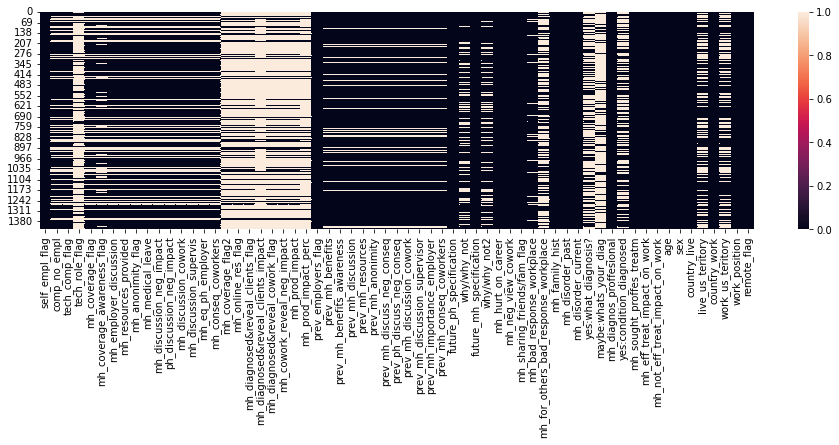

In [ ]:
# ----------- MISSING VALUES -----------
# Missing values visualisation
plt.figure(figsize = (16,4))
sns.heatmap(data = survey_2016.isna());

In [ ]:
# The survey has 1433 rows, so first we will drop all columns where more than half of the observations have missing values
cols = (survey_2016.isna().sum() >= survey_2016.shape[0]/2).tolist()
to_drop = survey_2016.columns[cols]
survey_2016.drop(labels = to_drop, axis = 1, inplace = True)

# Dealing with other missing values
from sklearn.impute import SimpleImputer

# Impute nan with the most frequent value (mode) on every row
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp.fit(survey_2016)
imp_data = pd.DataFrame(data = imp.transform(survey_2016), columns = survey_2016.columns)

In [ ]:
# ----------- ENCODING -----------
# Split data into 2 datasets: one that needs to be encoded, one that doesnt need to
cols = [x for x in imp_data.columns if x not in ['age', 'why/why_not', 'why/why_not2', 'country_live',
       'live_us_teritory', 'country_work', 'work_us_teritory', 'work_position']]

data_to_encode = imp_data[cols]
data_not_encode = imp_data[['why/why_not', 'why/why_not2', 'country_live',
       'live_us_teritory', 'country_work', 'work_us_teritory', 'work_position']]

# Importing OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

def encode(data):
    cat_columns = list(data.select_dtypes(include=['category','object']))
    column_mask = []

    for column_name in list(data.columns.values):
        column_mask.append(column_name in cat_columns)

    le = LabelEncoder()
    ohe = OneHotEncoder(sparse=False)

    for col in cat_columns:
        #data[col] = le.fit_transform(data[col])
        #print(data[col].to_numpy().shape)
        data[col] = ohe.fit_transform(data[col].to_numpy().reshape(-1, 1))
        #data[col] = integer_encoded.reshape(len(integer_encoded), 1)
    # print(data.iloc[0])

    # data = data.to_numpy()
    #data = ohe.fit_transform(data)

    return data

# encode(data_to_encode)
matrix = encode(data_to_encode)
encoded_data = pd.DataFrame(matrix) # to dataframe
encoded_data.columns = data_to_encode.columns

# Preprocessed data
prep_data = pd.concat(objs = [encoded_data, data_not_encode], axis = 1)

In [ ]:
# ----------- OTHER CHANGES -----------
# There are 53 total countries
# Out of all, most respondents are in US, UK, Canada, Germany, Netherlands and Australia.
# Usually, for a sample to be representative enough for the population, the size needs to be by convention >30.
# Respondents cannot be treated equaly within a response (different background, culture etc.), so we will exclude all nations
        #with a sample size smaller than 30. Because countries with no. responses > 30 are quite similar (well developed countries
        #with big economies and similar living standards), some of the analytics will incorporate all countries as one.

# Keep only countries with no. responses > 30.
imp_data = imp_data[imp_data['country_work'].isin(['USA', 'UK', 'Canada',
                                                   'Germany', 'Netherlands','Australia'])]
imp_data = imp_data[imp_data['country_live'].isin(['USA', 'UK', 'Canada',
                                                   'Germany', 'Netherlands','Australia'])]

prep_data = prep_data[prep_data['country_work'].isin(['USA', 'UK', 'Canada',
                                                   'Germany', 'Netherlands','Australia'])]
prep_data = prep_data[prep_data['country_live'].isin(['USA', 'UK', 'Canada',
                                                   'Germany', 'Netherlands','Australia'])]

# Unfortunatelly, the tech flag that identified if the respondent works/ doesn't work in tech had a lot of missing values
# So, we will need to map the 'work_position' column (that didn't have any missing values initially)
# Create the list with tech work positions
tech_list = []
tech_list.append(imp_data[imp_data['work_position'].str.contains('Back-end')]['work_position'].tolist())
tech_list.append(imp_data[imp_data['work_position'].str.contains('Front-end')]['work_position'].tolist())
tech_list.append(imp_data[imp_data['work_position'].str.contains('Dev')]['work_position'].tolist())
tech_list.append(imp_data[imp_data['work_position'].str.contains('DevOps')]['work_position'].tolist())

# Reshape the list (that is a list of lists) and remove duplicates
flat_list = [item for sublist in tech_list for item in sublist]
flat_list = list(dict.fromkeys(flat_list))

# Create a new column and recode it
imp_data['tech_flag'] = imp_data['work_position']
imp_data['tech_flag'].replace(to_replace = flat_list, value = 1, inplace = True)

# The other items - non tech
remain_list = imp_data['tech_flag'].unique()[1:].tolist()

imp_data['tech_flag'].replace(to_replace = remain_list, value = 0, inplace = True)

# The same for prep_data
# Create a new column and recode it
prep_data['tech_flag'] = prep_data['work_position']
prep_data['tech_flag'].replace(to_replace = flat_list, value = 1, inplace = True)

# The other items - non tech
prep_data['tech_flag'].replace(to_replace = remain_list, value = 0, inplace = True)

In [ ]:
import matplotlib as mpl
sns.set_style('whitegrid')
sns.set_palette('Set2')
mpl.rcParams['font.size'] = 16
import matplotlib.gridspec as gridspec

In [ ]:
imp_data[imp_data['tech_flag'] == 1]['age'].describe()

count     894.0
unique     48.0
top        30.0
freq       62.0
Name: age, dtype: float64

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing

In [ ]:
# Excluding non numeric columns from dataset
model_data = prep_data.copy()
col_numeric = [cols for cols in model_data.columns if model_data[cols].dtype in ['int64', 'float64']]
model_data = model_data[col_numeric]

# Model data is our new dataset for predicting variable 'mh_disorder_current'

# Feature variables and target variable
y = model_data['mh_disorder_current']

cols = [col for col in model_data.columns if col not in ['mh_disorder_current']]
X = model_data[cols]

# Data Validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Predefined function
def model_assess(model, name='Default'):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print('---', name, '---', '\n',
          confusion_matrix(y_test, preds), '\n',
          'Accuracy:', round(accuracy_score(y_test, preds), 5), '\n')

In [ ]:
# Naive Bayes
nb = GaussianNB()
model_assess(nb, name='Naive Bayes')

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, name='SGD')

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, name='KNN')

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, 'Decission Trees')

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, 'Random Forest')

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, 'SVM')

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, 'Logistic Regression')

# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(150, 10), random_state=1)
model_assess(nn, 'Neural Nets')

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, 'XGBoost')

# Cross Gradient Booster (Random Forest) <=================== BEST
xgbrf = XGBRFClassifier(objective= 'binary:logistic')
#xgbrf_param = xgbrf.get_xgb_params()
#xgbrf_param['num_class'] = 2
model_assess(xgbrf, 'XGBoost RF')

--- Naive Bayes --- 
 [[261  40]
 [ 27  43]] 
 Accuracy: 0.81941 

--- SGD --- 
 [[236  65]
 [ 20  50]] 
 Accuracy: 0.77089 

--- KNN --- 
 [[301   0]
 [ 68   2]] 
 Accuracy: 0.81671 

--- Decission Trees --- 
 [[232  69]
 [ 40  30]] 
 Accuracy: 0.7062 

--- Random Forest --- 
 [[294   7]
 [ 48  22]] 
 Accuracy: 0.85175 

--- SVM --- 
 [[279  22]
 [ 31  39]] 
 Accuracy: 0.85714 

--- Logistic Regression --- 
 [[284  17]
 [ 37  33]] 
 Accuracy: 0.85445 

--- Neural Nets --- 
 [[245  56]
 [ 44  26]] 
 Accuracy: 0.73046 

--- XGBoost --- 
 [[277  24]
 [ 33  37]] 
 Accuracy: 0.84636 

--- XGBoost RF --- 
 [[280  21]
 [ 31  39]] 
 Accuracy: 0.85984 



In [ ]:
from sklearn.model_selection import GridSearchCV

# Grid Search Function
def gridSearch(parameters):
    gsearch = GridSearchCV(estimator = XGBRFClassifier(learning_rate =0.00001,n_estimators=1000,max_depth=1,min_child_weight=4,
                                                    gamma=0.3,subsample=0.8,colsample_bytree=0.8,objective= 'binary:logistic',
                                                    nthread=4,scale_pos_weight=1),
                        param_grid = parameters, cv=5)
    gsearch.fit(X_train,y_train)
    print('best params:', gsearch.best_params_)
    predictions = gsearch.predict(X_test)
    print('Accuracy:', round(accuracy_score(y_test, predictions), 5))

In [ ]:
param_test1 = {
 'min_child_weight':[1, 2, 3, 4]
}
gridSearch(param_test1)


best params: {'min_child_weight': 2}
Accuracy: 0.83288


In [ ]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gridSearch(param_test2)

best params: {'gamma': 0.0}
Accuracy: 0.83288


In [ ]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gridSearch(param_test3)

best params: {'colsample_bytree': 0.9, 'subsample': 0.8}
Accuracy: 0.84906


In [ ]:
param_test5 = {
 'learning_rate':[1e-5, 1e-2, 0.1, 1, 100]
}

gridSearch(param_test5)

best params: {'learning_rate': 0.01}
Accuracy: 0.83558


In [ ]:
# Final Model
xgbrf_tuned = XGBRFClassifier(objective= 'binary:logistic', learning_rate =0.00001, n_estimators=1000, max_depth=1,
                              min_child_weight=5,gamma = 0.3, subsample=0.8, colsample_bytree=0.9,
                              nthread=4, scale_pos_weight=1)
model_assess(xgbrf_tuned)

--- Default --- 
 [[279  22]
 [ 34  36]] 
 Accuracy: 0.84906 



In [ ]:
!pip install eli5

     |████████████████████████████████| 216 kB 5.6 MB/s 
     |████████████████████████████████| 133 kB 60.6 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=81550985bd790ea73d0e3e58eb97d5ec660cbc33d785068ca7db1d4f5076562d
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
# How important is each variable into predicting if the respondent has a current Mental Health Problem?

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(estimator=xgbrf_tuned, random_state=1)
perm.fit(X_test, y_test)

eli5.show_weights(estimator=perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1121 ± 0.0130,mh_disorder_past
0.0038 ± 0.0088,mh_family_hist
0.0000 ± 0.0059,mh_bad_response_workplace
0 ± 0.0000,mh_anonimity_flag
0 ± 0.0000,prev_mh_benefits
0 ± 0.0000,prev_employers_flag
0 ± 0.0000,mh_conseq_coworkers
0 ± 0.0000,mh_eq_ph_employer
0 ± 0.0000,mh_discussion_supervis
0 ± 0.0000,mh_discussion_cowork


In [ ]:
# Creating new train datasets only with features that have an importance bigger than 0.004
X_train_new = X_train[['mh_disorder_past', 'mh_not_eff_treat_impact_on_work', 'mh_diagnos_proffesional',
                       'mh_eff_treat_impact_on_work']]
X_test_new = X_test[['mh_disorder_past', 'mh_not_eff_treat_impact_on_work', 'mh_diagnos_proffesional',
                       'mh_eff_treat_impact_on_work']]

# Fitting the model to the new train datasets to see if we get a better accuracy
xgbrf_perm_imp = XGBRFClassifier(objective= 'binary:logistic', learning_rate =0.00001, n_estimators=1000, max_depth=1,
                              min_child_weight=5,gamma = 0.3, subsample=0.8, colsample_bytree=0.9,
                              nthread=4, scale_pos_weight=1)
xgbrf_perm_imp.fit(X_train_new, y_train)
predictions = xgbrf_perm_imp.predict(X_test_new)
print(confusion_matrix(y_test, predictions))
print('Accuracy:', accuracy_score(y_test, predictions))

[[301   0]
 [ 70   0]]
Accuracy: 0.8113207547169812


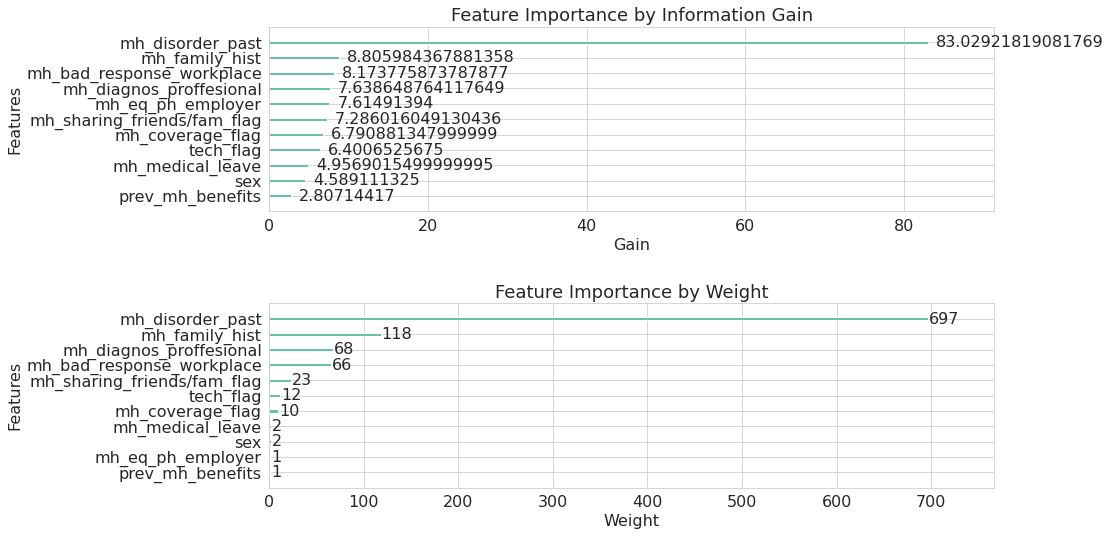

In [ ]:
from xgboost import plot_tree, plot_importance

fig, (ax1, ax2) = plt.subplots(figsize = (13, 8), ncols=1, nrows=2)
plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top = 0.9, wspace=0, hspace = 0.5)

plot_importance(xgbrf_tuned, importance_type='gain', ax = ax1)
ax1.set_title('Feature Importance by Information Gain', fontsize = 18)
ax1.set_xlabel('Gain')

plot_importance(xgbrf_tuned, importance_type='weight', ax = ax2)
ax2.set_title('Feature Importance by Weight', fontsize = 18)
ax2.set_xlabel('Weight');
